<a href="https://colab.research.google.com/github/utkarsh0702/Projects/blob/master/Missing_Value_Time_Series.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import tensorflow as tf
from tensorflow import keras
import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler

mpl.rcParams['figure.figsize'] = (10,8)
mpl.rcParams['axes.grid'] = False

In [3]:
result = pd.read_csv('new_train.csv', parse_dates=['Date'])
result['Date'] = pd.to_datetime(result['Date'], errors='coerce')
result

,Date,Open-Stock-1,High-Stock-1,Low-Stock-1,Close-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1,Open-Stock-2,High-Stock-2,Low-Stock-2,Close-Stock-2,VWAP-Stock-2,Volume-Stock-2,Turnover-Stock-2,Open-Stock-3,High-Stock-3,Low-Stock-3,Close-Stock-3,VWAP-Stock-3,Volume-Stock-3,Turnover-Stock-3,Open-Stock-4,High-Stock-4,Low-Stock-4,Close-Stock-4,VWAP-Stock-4,Volume-Stock-4,Turnover-Stock-4,Open-Stock-5,High-Stock-5,Low-Stock-5,Close-Stock-5,VWAP-Stock-5,Volume-Stock-5,Turnover-Stock-5
0,2010-06-01,1889.70,1890.00,1838.00,1855.10,1855.75,568273,105457457545000,285.40,285.95,281.50,283.00,283.72,3191773,90557243170000,2095.00,2097.80,2045.00,2077.25,2088.95,70547,14736933230000,851.65,864.80,833.10,837.95,844.44,3878011,327474904340000,1235.0,1238.00,1177.00,1181.70,1197.29,1786082,213845404410000
1,2010-06-02,1848.00,1862.75,1828.00,1853.05,1842.82,945167,174177161135000,284.00,284.80,279.25,281.30,281.05,2704797,76017076445000,2061.45,2098.00,2023.00,2079.85,2059.52,55547,11440017990000,844.70,849.90,823.00,842.30,838.31,3320996,278403743240000,1195.0,1206.95,1168.50,1201.15,1189.87,1307410,155564994855000
2,2010-06-03,1864.10,1910.00,1864.10,1905.60,1893.91,679689,128727119355000,283.00,286.85,282.50,285.50,285.34,2489752,71043460510000,2131.50,2131.50,2091.05,2114.90,2107.84,55130,11620529360000,851.40,859.05,848.20,854.10,853.51,2494522,212910342645000,1211.0,1248.00,1211.00,1242.30,1231.63,1482919,182640434320000
3,2010-06-04,1906.00,1909.80,1880.10,1885.70,1889.21,509435,96242800140000,288.85,291.80,277.00,290.85,289.81,3188813,92414802585000,2114.90,2156.00,2095.50,2146.75,2145.36,29302,6286330280000,854.10,868.60,854.10,865.85,862.85,2963920,255740999120000,1240.0,1258.00,1240.00,1245.45,1249.72,1454459,181767075850000
4,2010-06-07,1867.00,1894.85,1808.35,1876.65,1873.32,961913,180196832650000,285.00,289.10,285.00,287.70,287.01,2198836,63109395135000,2132.35,2209.00,2112.00,2185.25,2180.52,78919,17208425860000,712.00,850.00,712.00,841.95,839.89,3471483,291567400640000,1218.6,1225.00,1196.00,1214.80,1209.27,1424594,172272511430000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,2011-07-28,499.50,499.50,484.60,487.30,489.79,5354489,262255417380000,198.35,207.00,198.35,206.25,204.68,16270594,333026806690000,3105.85,3143.00,3105.85,3120.85,3121.98,155200,48453078985000,1012.10,1035.50,1010.00,1017.45,1021.77,3823471,390670692820000,1285.0,1307.95,1285.00,1301.50,1297.00,1353005,175484999030000
295,2011-07-29,489.90,489.90,481.10,486.80,485.65,2997667,145582296035000,205.50,211.25,205.25,208.35,208.89,13288551,277587677435000,3122.40,3140.05,3115.00,3134.00,3129.24,28578,8942753035000,1011.00,1051.00,1003.60,1036.75,1032.52,6537105,674969821765000,1300.0,1342.00,1292.40,1337.50,1325.46,1850972,245338665665000
296,2011-08-01,493.45,495.95,484.50,488.00,489.14,2202354,107726909450000,210.00,211.25,208.10,208.90,209.13,7104094,148570564060000,3141.95,3163.00,3053.50,3067.85,3100.07,36332,11263166685000,1052.80,1059.70,1038.70,1045.35,1049.87,2088359,219249912200000,1349.0,1367.55,1346.50,1353.00,1357.02,1226610,166453494180000
297,2011-08-02,487.90,487.90,480.00,482.85,483.30,1982494,95814144795000,207.70,208.35,202.85,204.75,205.13,7645467,156835059215000,3067.85,3069.00,3001.10,3052.15,3047.39,177189,53996461955000,1039.90,1041.35,1018.10,1021.70,1025.73,2925557,300083555650000,1345.0,1347.95,1326.10,1342.80,1334.07,970086,129416608470000


In [20]:
df1= result.loc[:,['Date','Open-Stock-1', 'High-Stock-1', 'Low-Stock-1', 'Close-Stock-1', 'VWAP-Stock-1', 'Volume-Stock-1', 'Turnover-Stock-1']]
df1.head()

,Date,Open-Stock-1,High-Stock-1,Low-Stock-1,Close-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1
0,2010-06-01,1889.7,1890.00,1838.00,1855.10,1855.75,568273,105457457545000
1,2010-06-02,1848.0,1862.75,1828.00,1853.05,1842.82,945167,174177161135000
2,2010-06-03,1864.1,1910.00,1864.10,1905.60,1893.91,679689,128727119355000
3,2010-06-04,1906.0,1909.80,1880.10,1885.70,1889.21,509435,96242800140000
4,2010-06-07,1867.0,1894.85,1808.35,1876.65,1873.32,961913,180196832650000


In [21]:
df1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 0 to 298
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   Date              299 non-null    datetime64[ns]
 1   Open-Stock-1      299 non-null    float64       
 2   High-Stock-1      299 non-null    float64       
 3   Low-Stock-1       299 non-null    float64       
 4   Close-Stock-1     299 non-null    float64       
 5   VWAP-Stock-1      299 non-null    float64       
 6   Volume-Stock-1    299 non-null    int64         
 7   Turnover-Stock-1  299 non-null    int64         
dtypes: datetime64[ns](1), float64(5), int64(2)
memory usage: 18.8 KB


In [22]:
idx = pd.date_range(df1.Date.min(), df1.Date.max())
df1.set_index('Date', inplace=True)

In [23]:
df1

,Open-Stock-1,High-Stock-1,Low-Stock-1,Close-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1
Date,,,,,,,
2010-06-01,1889.70,1890.00,1838.00,1855.10,1855.75,568273,105457457545000
2010-06-02,1848.00,1862.75,1828.00,1853.05,1842.82,945167,174177161135000
2010-06-03,1864.10,1910.00,1864.10,1905.60,1893.91,679689,128727119355000
2010-06-04,1906.00,1909.80,1880.10,1885.70,1889.21,509435,96242800140000
2010-06-07,1867.00,1894.85,1808.35,1876.65,1873.32,961913,180196832650000
...,...,...,...,...,...,...,...
2011-07-28,499.50,499.50,484.60,487.30,489.79,5354489,262255417380000
2011-07-29,489.90,489.90,481.10,486.80,485.65,2997667,145582296035000
2011-08-01,493.45,495.95,484.50,488.00,489.14,2202354,107726909450000


**Cubic Spline interpolation**

In [32]:
df1 = df1.reindex(idx)
df1.index.name = 'Date'
# df1= df1.replace({0:np.NaN})
df1= df1.interpolate(method='spline', order=3, s=0.)
df1

,Open-Stock-1,High-Stock-1,Low-Stock-1,Close-Stock-1,VWAP-Stock-1,Volume-Stock-1,Turnover-Stock-1
Date,,,,,,,
2010-06-01,1889.700000,1890.000000,1838.000000,1855.100000,1855.750000,5.682730e+05,1.054575e+14
2010-06-02,1848.000000,1862.750000,1828.000000,1853.050000,1842.820000,9.451670e+05,1.741772e+14
2010-06-03,1864.100000,1910.000000,1864.100000,1905.600000,1893.910000,6.796890e+05,1.287271e+14
2010-06-04,1906.000000,1909.800000,1880.100000,1885.700000,1889.210000,5.094350e+05,9.624280e+13
2010-06-05,1905.760161,1899.169574,1850.757012,1873.500541,1876.344604,6.990157e+05,1.307538e+14
...,...,...,...,...,...,...,...
2011-07-30,487.361481,489.552328,482.209168,490.040184,487.080278,1.471547e+06,7.112750e+13
2011-07-31,491.319471,494.996056,484.576995,490.669041,489.797669,1.703573e+06,8.323837e+13
2011-08-01,493.450000,495.950000,484.500000,488.000000,489.140000,2.202354e+06,1.077269e+14


In [37]:
df2 = df1.loc[:,['Close-Stock-1']]
df2 = df2.set_index(df1.index)
array = df2.to_numpy().reshape(-1,1)
array.shape

(429, 1)

In [38]:
#taking mean and standered deviation
array_mean = array.mean()
array_std = array.std()
#normalizing the data
array = (array-array_mean)/array_std

In [39]:
def univariate_data(dataset, start_index, end_index, history_size, target_size):
  data = []
  labels = []

  start_index = start_index + history_size
  if end_index is None:
    end_index = len(dataset) - target_size

  for i in range(start_index, end_index):
    indices = range(i-history_size, i)
    # Reshape data from (history_size,) to (history_size, 1)
    data.append(np.reshape(dataset[indices], (history_size, 1)))
    labels.append(dataset[i+target_size])
  return np.array(data), np.array(labels)

In [40]:
univariate_past_history = 12
univariate_future_target = 0

x, y = univariate_data(array, 0, None, univariate_past_history, univariate_future_target)

In [41]:
print('X Shape:',x.shape)
print('Y Shape:',y.shape)

X Shape: (417, 12, 1)
Y Shape: (417, 1)


## Learning Rate Scheduling

In [42]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1),
                                   tf.keras.layers.Dropout(0.15),
                                   tf.keras.layers.Dense(1),
                                   ])
lr_schedular= tf.keras.callbacks.LearningRateScheduler(lambda x: 1e-6*10**(x/20))

adam= tf.keras.optimizers.Adam(lr=1e-6)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [43]:
history= model.fit(x, y, epochs= 125, callbacks= [lr_schedular])

Epoch 1/125
14/14 [==============================] - 12s 38ms/step - loss: 1.0641
Epoch 2/125
14/14 [==============================] - 1s 38ms/step - loss: 0.9376
Epoch 3/125
14/14 [==============================] - 1s 38ms/step - loss: 1.1698
Epoch 4/125
14/14 [==============================] - 1s 39ms/step - loss: 1.2380
Epoch 5/125
14/14 [==============================] - 1s 38ms/step - loss: 0.9186
Epoch 6/125
14/14 [==============================] - 1s 38ms/step - loss: 0.9329
Epoch 7/125
14/14 [==============================] - 1s 37ms/step - loss: 0.8649
Epoch 8/125
14/14 [==============================] - 1s 38ms/step - loss: 0.9247
Epoch 9/125
14/14 [==============================] - 1s 37ms/step - loss: 1.1103
Epoch 10/125
14/14 [==============================] - 1s 37ms/step - loss: 1.0871
Epoch 11/125
14/14 [==============================] - 1s 37ms/step - loss: 1.0555
Epoch 12/125
14/14 [==============================] - 1s 38ms/step - loss: 0.8925
Epoch 13/125
14/14 [====

In [44]:
loss= min(history.history['loss'])
losses= history.history['loss']
index=losses.index(loss)
lrs= history.history['lr']
count=0
for i in lrs:
  if count==index:
    lr=i
    break
  count+=1
print(lr)
print(loss)

0.01
0.14674519002437592


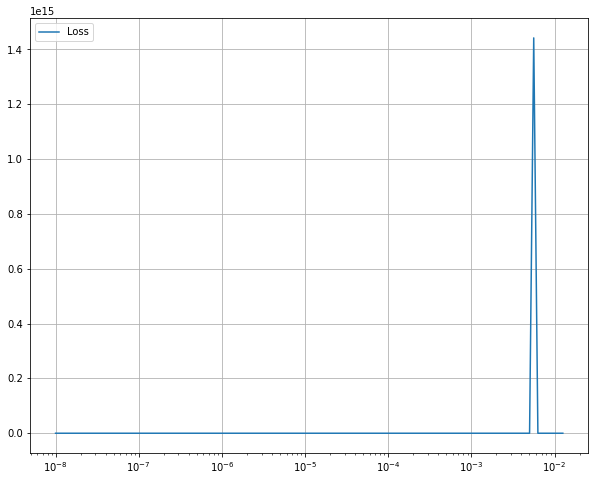

In [45]:
lrs= 1e-8*(10**(np.arange(125)/20))
plt.semilogx(lrs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

## Model Training

In [46]:
tf.keras.backend.clear_session()

#creating model
model= tf.keras.models.Sequential([
                                   tf.keras.layers.Lambda(lambda x: tf.expand_dims(x,axis=-1), input_shape=[None]),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(24, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1, return_sequences=True)),
                                   tf.keras.layers.LSTM(12, activation='relu', dropout=0.25, recurrent_dropout=0.1),
                                   tf.keras.layers.Dropout(0.15),
                                   tf.keras.layers.Dense(1),
                                   ])

adam= tf.keras.optimizers.Adam(lr=lr)
model.compile(optimizer= adam, loss= 'mse')
#Smodel.build(input_shape)
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, None, 1)           0         
_________________________________________________________________
bidirectional (Bidirectional (None, None, 48)          4992      
_________________________________________________________________
bidirectional_1 (Bidirection (None, None, 24)          5856      
_________________________________________________________________
lstm_2 (LSTM)                (None, 12)                1776      
_________________________________________________________________
dropout (Dropout)            (None, 12)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 13        
Total params: 12,637
Trainable params: 12,637
Non-trainable params: 0
____________________________________________________

In [50]:
history= model.fit(x,y, epochs= 300)

Epoch 1/50
14/14 [==============================] - 1s 37ms/step - loss: 0.1261
Epoch 2/50
14/14 [==============================] - 1s 39ms/step - loss: 0.1657
Epoch 3/50
14/14 [==============================] - 1s 38ms/step - loss: 0.2108
Epoch 4/50
14/14 [==============================] - 1s 37ms/step - loss: 0.2332
Epoch 5/50
14/14 [==============================] - 1s 38ms/step - loss: 0.2013
Epoch 6/50
14/14 [==============================] - 1s 37ms/step - loss: 0.1608
Epoch 7/50
14/14 [==============================] - 1s 38ms/step - loss: 0.2208
Epoch 8/50
14/14 [==============================] - 1s 37ms/step - loss: 0.1481
Epoch 9/50
14/14 [==============================] - 1s 37ms/step - loss: 0.1570
Epoch 10/50
14/14 [==============================] - 1s 38ms/step - loss: 0.1251
Epoch 11/50
14/14 [==============================] - 1s 38ms/step - loss: 0.1778
Epoch 12/50
14/14 [==============================] - 1s 40ms/step - loss: 0.1277
Epoch 13/50
14/14 [==================

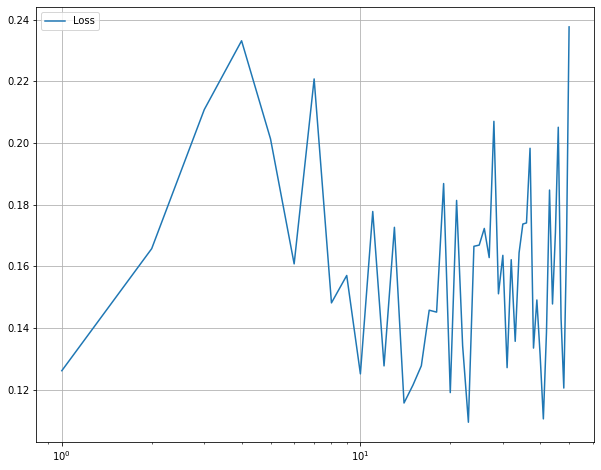

In [51]:
epochs= range(1,301)
plt.semilogx(epochs, history.history["loss"], label='Loss')
plt.legend(loc='best')
plt.grid(True)

(417, 12, 1)
(417, 1)


[]

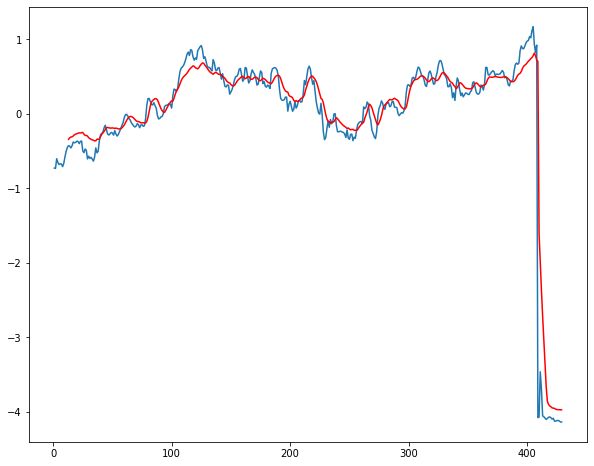

In [52]:
numbers=range(1, 430)
num= range(13,430)
plt.figure()
print(x.shape)
y_pred= model.predict(x)
print(y_pred.shape)
plt.plot(numbers,array)
plt.plot(num,y_pred,'r')
plt.plot()

**Test Phase**